# Simple (no w-projection) dirty image generation from OSKAR simulated VLA data.

In [7]:
%matplotlib inline
import sys
import os
import math
import time
import numpy
from matplotlib import pyplot as plt
import pyfits
sys.path.append(os.path.join('oskar_data', 'scripts'))
from read_oskar_vis import OskarVis
from parula import parula_map
cmap = 'rainbow'

### 0. Define imaging and gridding parameters

In [8]:
fov = 3.0         # field-of-view, in degrees
imsize = 1024     # Image dimension / grid size, in pixels
support = 3       # GCF support (width = 2 * support + 1)
oversample = 100  # GCF oversample (values per grid cell)

# Visibility file and comparision CASA fits image.
vis_file = os.path.join('oskar_data', 'vla_grid_6h', 'test_vla.vis')
fits_file = os.path.join('oskar_data', 'vla_grid_6h', 
                         'test_vla_dirty_s%04i_f%04.1f_w000.fits' % (imsize, fov))
# vis_file = os.path.join('oskar_data', 'vla_1src_6h', 'test_vla.vis')
# fits_file = os.path.join('oskar_data', 'vla_1src_6h', 
#                          'test_vla_dirty_0%04i_w000.fits' % imsize)
   

def fov_to_cell_size(fov, im_size):
    """Evaluate image pixel size (in arcseconds) for a given FoV and number of pixels."""
    r_max = math.sin(math.radians(fov) / 2.0)
    inc = r_max / (0.5 * im_size)
    return math.degrees(math.asin(inc)) * 3600.0

def grid_cell_size(cell_size_lm_arcsec, im_size):
    """Obtain grid cell size from image cell size."""
    return (180. * 3600.) / (im_size * cell_size_lm_arcsec * math.pi)

# Image pixel separation, in arcseconds
cell_size_lm_arcsec = fov_to_cell_size(fov, imsize)
# Grid pixel separation, in wavelengths.
cell_size_uv = grid_cell_size(cell_size_lm_arcsec, imsize)

### 1. Generate GCF

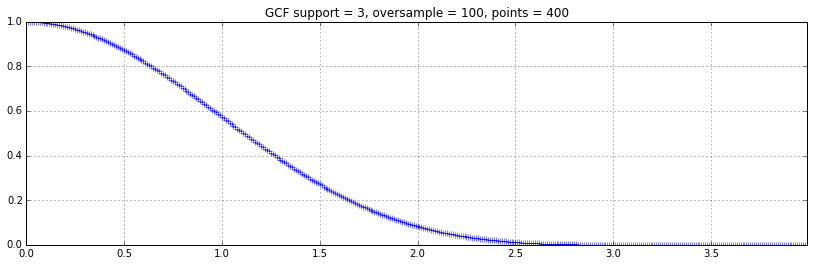

In [9]:
def grdsf(nu):
    P = [8.203343e-2, -3.644705e-1, 6.278660e-1, -5.335581e-1, 2.312756e-1,
         4.028559e-3, -3.697768e-2, 1.021332e-1, -1.201436e-1, 6.412774e-2]
    Q = [1.0000000e0, 8.212018e-1, 2.078043e-1, 1.0000000e0, 9.599102e-1, 2.918724e-1]
    p = numpy.array(P, dtype='f8').reshape(2, 5)
    q = numpy.array(Q, dtype='f8').reshape(2, 3)
    val = 0.0
    if nu >= 0.0 and nu < 0.75:
        part = 0
        nuend = 0.75
    elif nu >= 0.75 and nu <= 1.0:
        part = 1
        nuend = 1.0
    else:
        val = 0.0
        return val
    top = p[part, 0]
    delnusq = nu**2 - nuend**2
    for k in range(1, 5):
        top += p[part, k] * delnusq**(k)
    bot = q[part, 0]
    for k in range(1, 3):
        bot += q[part, k] * delnusq**(k)
    if bot != 0.0:
        val = top / bot
    else:
        val = 0.0     
    return val


gcf_size = oversample * (support + 1)
convFunc = numpy.empty(gcf_size)
nu = numpy.empty(gcf_size)
for i in range(0, gcf_size):
    nu[i] = float(i) / (support * oversample)
    val = grdsf(nu[i])
    convFunc[i] = (1.0 - nu[i]**2) * val
   
# Plot the GCF
convFunc_u = numpy.arange(0, gcf_size, dtype='f8') / (oversample)
fig = plt.figure(figsize=(14, 4))
plt.plot(convFunc_u, convFunc, '+')
plt.xlim(numpy.min(convFunc_u), numpy.max(convFunc_u))
plt.title('GCF support = %i, oversample = %i, points = %i' % (support, oversample, convFunc.shape[0]))
plt.grid(True)

### 2. Load visibility data.

In [10]:
# Read visibility binary and scale into wavelengths.
oskar_vis = OskarVis(vis_file)
uu, vv, ww = oskar_vis.uvw(flatten=True)
freq_hz = oskar_vis.frequency()
wave_length_m = 299792458.0 / freq_hz
uu =  numpy.array(uu, dtype='f8') / wave_length_m
vv =  numpy.array(vv, dtype='f8') / wave_length_m
uvw = numpy.array([uu, vv, ww]) / wave_length_m
amp = oskar_vis.stokes_i(flatten=True)
# Append hermitian copy of visibilities.
# uu = numpy.hstack((uu, -uu))
# vv = numpy.hstack((vv, -vv))
# amp = numpy.hstack((amp, numpy.conj(amp)))
nvis = uu.shape[0]

### 3. Gridding! 

In [11]:
g_centre = imsize / 2
grid = numpy.zeros((imsize, imsize), dtype='c16')
g_sum = 0.0
csize = support * 2 + 1
cxy = numpy.zeros((csize, csize), dtype='f8')
t0 = time.time()
nskip = 0
for i in range(0, nvis):
    pos_x = -uu[i] / cell_size_uv
    pos_y = vv[i] / cell_size_uv
    grid_x = int(round(pos_x)) + g_centre
    grid_y = int(round(pos_y)) + g_centre

    if grid_x + (support * 1.5) >= imsize or grid_x - (support * 1.5) < 0:
        nskip += 1
        continue
    if grid_y + (support * 1.5) >= imsize or grid_y - (support * 1.5) < 0:
        nskip += 1
        continue
        
    # Scaled distance from nearest grid point
    off_x = int(round((grid_x - g_centre - pos_x) * oversample))
    off_y = int(round((grid_y - g_centre - pos_y) * oversample))
    
    for j in range(0, csize):
        cy = convFunc[abs(off_y + (j - support) * oversample)]
        for k in range(0, csize):
            cx = convFunc[abs(off_x + (k - support) * oversample)]
            cxy[j, k] = cx * cy
    
    grid[grid_y-support:grid_y+support+1, grid_x-support:grid_x+support+1] += cxy * amp[i]
    
    g_sum += numpy.sum(cxy)
    
# Normalise grid.
grid /= g_sum    
print 'Time taken = %.3fs' % (time.time() - t0)
assert nskip == 0, "data points outside the grid is currently not handled properly by this code"

Time taken = 2.627s


### 4. Grid -> image

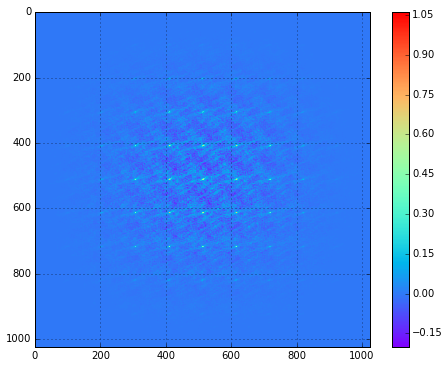

In [12]:
image = numpy.fft.fftshift(numpy.fft.fft2(numpy.fft.fftshift(grid)))

fig = plt.figure(figsize=(16/2, 6))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(image.real, interpolation='nearest', cmap=cmap)
plt.colorbar(im)
# ax.grid(color='white')
# ax = fig.add_subplot(122, aspect='equal')
# im = ax.imshow(image.imag, interpolation='nearest', cmap=cmap)
# plt.colorbar(im)
ax.grid()

### 5. Generate GCF correction

In [13]:
corrFunc = numpy.zeros(imsize, dtype='f8')
corr_nu = numpy.empty(imsize, dtype='f8')
for i in range(0, imsize):
    offset = i - imsize / 2
    corr_nu[i] = float(offset) / float(imsize / 2)
    val = grdsf(abs(corr_nu[i]))
    if val != 0.0:
        corrFunc[i] = 1.0 / val
        
# fig = plt.figure()        
# plt.semilogy(corr_nu, corrFunc, 'b-')
# plt.title('correction function')

corrFunc_2d = numpy.zeros((imsize, imsize), dtype='f8')
for i in range(0, imsize):
    corrFunc_2d[i, :] = corrFunc
for i in range(0, imsize):
    corrFunc_2d[:, i] *= corrFunc


### 6. Correct image for GCF and plot corrected image.

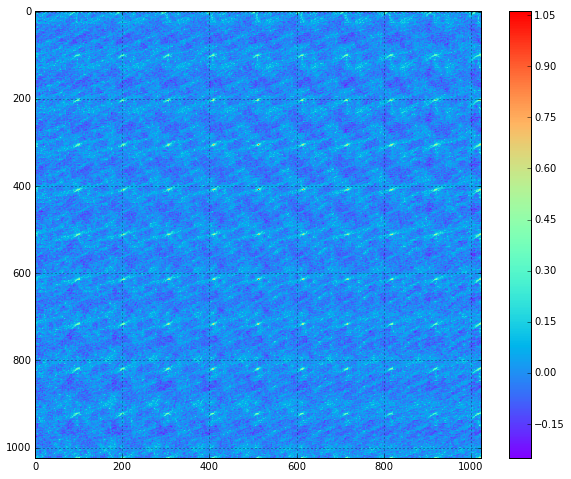

In [14]:
corrected_image = image.real * corrFunc_2d
z = 0
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(corrected_image[z:imsize-z, z:imsize-z], interpolation='nearest', cmap=cmap)
plt.colorbar(im)
ax.grid(True)

### 6. Load Reference CASA image

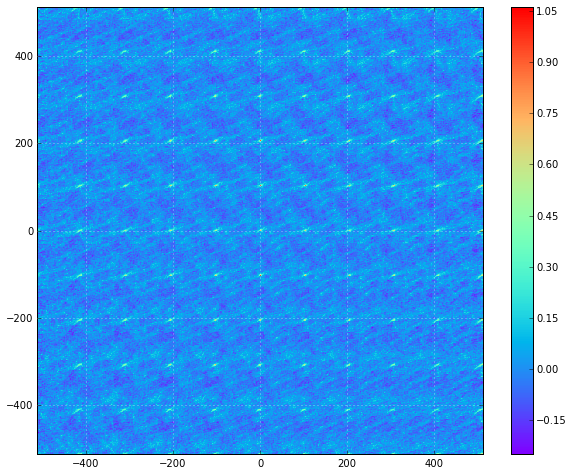

In [15]:
casa_image = numpy.squeeze(pyfits.getdata(fits_file))
plt.close('casa image')
z = 0
fig = plt.figure('casa image', figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
extent = [-imsize/2, imsize/2, -imsize/2, imsize/2]
im = ax.imshow(casa_image[z:imsize-z, z:imsize-z], interpolation='nearest', 
               extent=extent, cmap=cmap)
plt.colorbar(im)
ax.grid(True, color='white')

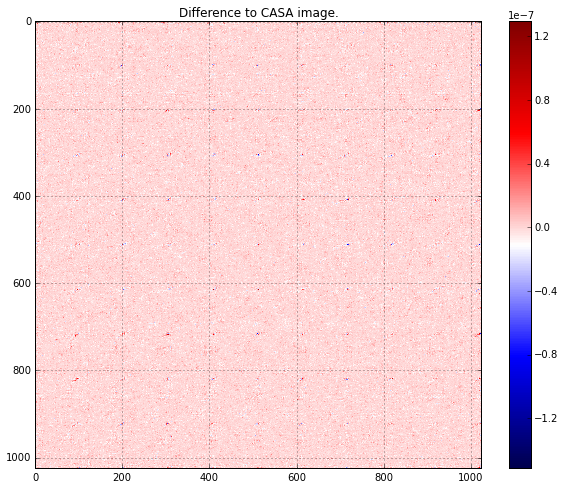

In [16]:
diff = casa_image - corrected_image.real
z = 0
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect='equal')
im = ax.imshow(diff[z:imsize-z,z:imsize-z], interpolation='nearest', cmap='seismic')
ax.set_title('Difference to CASA image.')
plt.colorbar(im)
ax.grid(True)